In [0]:
!wget https://www.machinehack.com/wp-content/uploads/2020/05/Financial_Risk_Participants_Data.zip

--2020-05-16 15:40:39--  https://www.machinehack.com/wp-content/uploads/2020/05/Financial_Risk_Participants_Data.zip
Resolving www.machinehack.com (www.machinehack.com)... 107.180.71.20
Connecting to www.machinehack.com (www.machinehack.com)|107.180.71.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20635 (20K) [application/zip]
Saving to: ‘Financial_Risk_Participants_Data.zip’

Financial_Risk_Part 100%[===================>]  20.15K  --.-KB/s    in 0.07s   

2020-05-16 15:40:39 (286 KB/s) - ‘Financial_Risk_Participants_Data.zip’ saved [20635/20635]



In [0]:
!unzip Financial_Risk_Participants_Data.zip

Archive:  Financial_Risk_Participants_Data.zip
   creating: Financial_Risk_Participants_Data/
  inflating: Financial_Risk_Participants_Data/.DS_Store  
  inflating: __MACOSX/Financial_Risk_Participants_Data/._.DS_Store  
  inflating: Financial_Risk_Participants_Data/Test.csv  
  inflating: __MACOSX/Financial_Risk_Participants_Data/._Test.csv  
  inflating: Financial_Risk_Participants_Data/Sample_Submission.xlsx  
  inflating: __MACOSX/Financial_Risk_Participants_Data/._Sample_Submission.xlsx  
  inflating: Financial_Risk_Participants_Data/Train.csv  
  inflating: __MACOSX/Financial_Risk_Participants_Data/._Train.csv  


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
train = pd.read_csv('Financial_Risk_Participants_Data/Train.csv')
test = pd.read_csv('Financial_Risk_Participants_Data/Test.csv')
sub = pd.read_excel('Financial_Risk_Participants_Data/Sample_Submission.xlsx')

In [0]:
train.head(5)

,City,Location_Score,Internal_Audit_Score,External_Audit_Score,Fin_Score,Loss_score,Past_Results,IsUnderRisk
0,2,8.032,14,8,3,6,0,1
1,31,77.730,8,3,3,8,1,0
2,40,59.203,3,12,11,3,0,1
3,12,73.080,4,5,7,6,0,0
4,4,15.666,13,15,6,7,2,1


In [0]:
test.head(5)

,City,Location_Score,Internal_Audit_Score,External_Audit_Score,Fin_Score,Loss_score,Past_Results
0,41,18.272,13,12,9,7,0
1,17,64.799,6,10,7,4,1
2,31,68.890,3,3,7,8,0
3,3,16.492,15,10,7,4,1
4,9,17.178,7,3,8,3,1


In [0]:
train_df=train
test_df=test

In [0]:
X = train_df.drop(labels=['IsUnderRisk'], axis=1)
y = train_df['IsUnderRisk'].values

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [0]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((434, 7), (434,), (109, 7), (109,))

In [0]:
from sklearn.metrics import log_loss

In [0]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'multiclass',
         'num_class': 2,
         'boosting': 'gbdt',  
         'metric': 'multi_logloss',
         'learning_rate': 0.01, 
         'num_iterations': 2000,
         'num_leaves': 100,
         'max_depth': -1,
         'min_data_in_leaf': 15,
         'bagging_fraction':0.9,
         'bagging_freq': 1,
         'feature_fraction': 0.7,
         'lambda_l2': 0.8,
         'min_data_per_group': 75,
         'max_bin': 255,
         'is_unbalance':False
         }

clf = lgb.train(params=param, 
                early_stopping_rounds=200,
                verbose_eval=100,
                train_set=train_data,
                valid_sets=[test_data])

y_pred = clf.predict(X_cv)

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.377877
[200]	valid_0's multi_logloss: 0.267447
[300]	valid_0's multi_logloss: 0.212838
[400]	valid_0's multi_logloss: 0.177969
[500]	valid_0's multi_logloss: 0.154966
[600]	valid_0's multi_logloss: 0.137252
[700]	valid_0's multi_logloss: 0.121836
[800]	valid_0's multi_logloss: 0.107928
[900]	valid_0's multi_logloss: 0.0968413
[1000]	valid_0's multi_logloss: 0.0867392
[1100]	valid_0's multi_logloss: 0.0778006
[1200]	valid_0's multi_logloss: 0.0702756
[1300]	valid_0's multi_logloss: 0.0639908
[1400]	valid_0's multi_logloss: 0.0582415
[1500]	valid_0's multi_logloss: 0.0530651
[1600]	valid_0's multi_logloss: 0.0486719
[1700]	valid_0's multi_logloss: 0.0449088
[1800]	valid_0's multi_logloss: 0.0418881
[1900]	valid_0's multi_logloss: 0.039223
[2000]	valid_0's multi_logloss: 0.0365615
Did not meet early stopping. Best iteration is:
[2000]	valid_0's multi_logloss: 0.0365615


In [0]:
log_loss(y_cv, y_pred)

0.03656149181025572

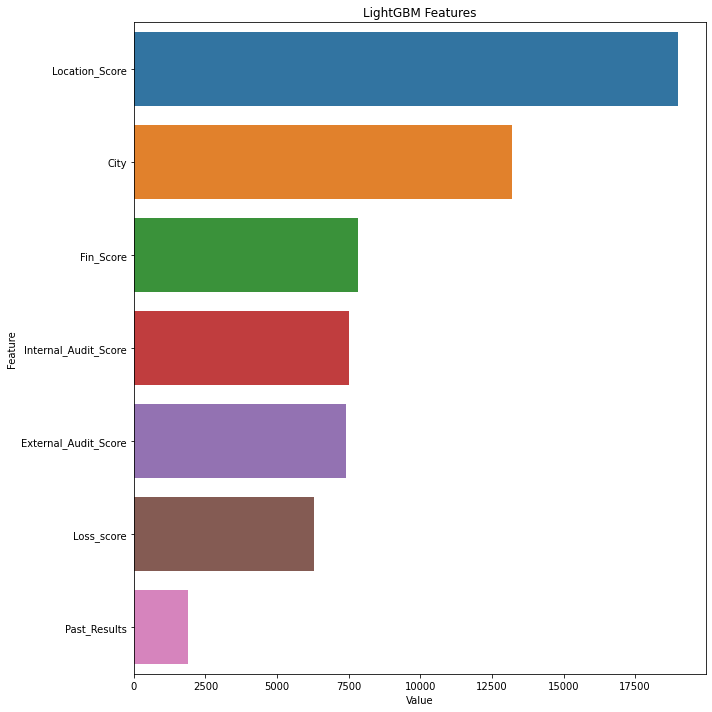

In [0]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(), X.columns), reverse=True)[:], columns=['Value','Feature'])
plt.figure(figsize=(10,10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [0]:
feature_imp.loc[feature_imp.Value >= 0].sort_values(by=['Value'], ascending = False)

,Value,Feature
0,19010,Location_Score
1,13202,City
2,7833,Fin_Score
3,7514,Internal_Audit_Score
4,7413,External_Audit_Score
5,6298,Loss_score
6,1883,Past_Results


In [0]:
Xtest = test_df

In [0]:

from sklearn.model_selection import KFold, StratifiedKFold

errlgb = []
y_pred_totlgb = []

fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123456789)

for train_index, test_index in fold.split(X, y):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    
    clf = lgb.train(params=param,
                     early_stopping_rounds=200,
                     verbose_eval=100,
                     train_set=train_data,
                     valid_sets=[test_data])

    y_pred = clf.predict(X_test)
    print("Log Loss: ", (log_loss(y_test, y_pred)))
    
    errlgb.append(log_loss(y_test, y_pred))
    p = clf.predict(Xtest)
    y_pred_totlgb.append(p)

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.449518
[200]	valid_0's multi_logloss: 0.385314
[300]	valid_0's multi_logloss: 0.372264
[400]	valid_0's multi_logloss: 0.376253
[500]	valid_0's multi_logloss: 0.391029
Early stopping, best iteration is:
[338]	valid_0's multi_logloss: 0.371243
Log Loss:  0.3712430100400777
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.434234
[200]	valid_0's multi_logloss: 0.359261
[300]	valid_0's multi_logloss: 0.336501
[400]	valid_0's multi_logloss: 0.331562
[500]	valid_0's multi_logloss: 0.338511
[600]	valid_0's multi_logloss: 0.346519
Early stopping, best iteration is:
[401]	valid_0's multi_logloss: 0.331474
Log Loss:  0.3314742304027437
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.46153
[200]	valid_0's multi_logloss: 0.386336
[300]	valid_0's multi_logloss: 0.353286
[400]	valid_0's multi_logloss: 0.335484
[5

In [0]:
np.mean(errlgb,0)

0.2785578027141532

In [0]:
sub.columns


Int64Index([0, 1], dtype='int64')

In [0]:
y_pred = np.mean(y_pred_totlgb,0)

In [0]:
submission = pd.DataFrame(data=y_pred, columns=sub.columns)
submission.head()

,0,1
0,0.006531,0.993469
1,0.150164,0.849836
2,0.907132,0.092868
3,0.007890,0.992110
4,0.137248,0.862752


In [0]:
submission.to_excel('f2.xlsx', index=False)

In [0]:
from google.colab import files
files.download('f2.xlsx')

In [0]:
TARGET_COL = 'IsUnderRisk'

In [0]:
test.reset_index(drop=True, inplace=True)
target = train[TARGET_COL]
features = [c for c in train.columns if c not in [TARGET_COL]]

In [0]:

X_trn, X_val, y_trn, y_val = train_test_split(train[features], target, test_size=0.1, stratify=target, random_state=10)
X_test = test[features]

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from tqdm import tqdm_notebook
from sklearn.utils import shuffle
clf = LGBMClassifier(learning_rate=0.01, colsample_bytree=0.3, reg_alpha=3, reg_lambda=3, max_depth=-1, n_estimators=2000, min_child_samples=15, num_leaves=141)
_ = clf.fit(X_trn, y_trn, eval_set=[(X_trn, y_trn), (X_val, y_val)], verbose=100, early_stopping_rounds=100)
predictions_val_lgb = clf.predict_proba(X_val)
print(f"Log loss for Model 1 is: {log_loss(y_val, predictions_val_lgb)}")

Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.501948	valid_1's binary_logloss: 0.499079
[200]	training's binary_logloss: 0.413423	valid_1's binary_logloss: 0.402417
[300]	training's binary_logloss: 0.370035	valid_1's binary_logloss: 0.354261
[400]	training's binary_logloss: 0.339677	valid_1's binary_logloss: 0.317085
[500]	training's binary_logloss: 0.321145	valid_1's binary_logloss: 0.293385
[600]	training's binary_logloss: 0.307554	valid_1's binary_logloss: 0.275374
[700]	training's binary_logloss: 0.296207	valid_1's binary_logloss: 0.260947
[800]	training's binary_logloss: 0.288446	valid_1's binary_logloss: 0.251388
[900]	training's binary_logloss: 0.282363	valid_1's binary_logloss: 0.243987
[1000]	training's binary_logloss: 0.277371	valid_1's binary_logloss: 0.237572
[1100]	training's binary_logloss: 0.27283	valid_1's binary_logloss: 0.232275
[1200]	training's binary_logloss: 0.269197	valid_1's binary_logloss: 0.228086
[1300]	trai

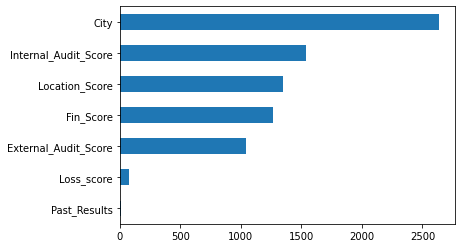

In [0]:
fi = pd.Series(index=features, data = clf.feature_importances_)
fi.sort_values(ascending=False)[:20][::-1].plot.barh()

In [0]:
predictions_test_lgb = clf.predict_proba(X_test)

In [0]:
submission = pd.DataFrame(data=predictions_test_lgb, columns=sub.columns)
submission.head()

,0,1
0,0.002680,0.997320
1,0.363818,0.636182
2,0.880036,0.119964
3,0.007793,0.992207
4,0.267502,0.732498


In [0]:
submission.to_excel('Output6.xlsx', index=False)

In [0]:
from google.colab import files
files.download('Output6.xlsx')

# Ngboost

In [0]:
!pip install ngboost

     |████████████████████████████████| 327kB 5.6MB/s 


In [0]:
from ngboost import NGBRegressor
ngb = NGBRegressor(verbose=1, learning_rate=0.1, n_estimators=100, random_state=101)
ngb.fit(X_train, y_train)
y_pred = ngb.predict(X_cv)
print('score', log_loss(y_cv, y_pred))

[iter 0] loss=0.6927 val_loss=0.0000 scale=2.0000 norm=1.0640
score 0.2558396626370604


In [0]:
Xtest = test_df

In [0]:
from sklearn.model_selection import KFold

errgb = []
y_pred_totgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
             
    ngb = NGBRegressor(learning_rate=0.1, n_estimators=100, random_state=101)
    ngb.fit(X_train, y_train)
    y_pred = ngb.predict(X_test)
    print('Score', log_loss(y_test, y_pred))

    errgb.append(log_loss(y_test, y_pred))
    p = ngb.predict(Xtest)
    y_pred_totgb.append(p)

[iter 0] loss=0.6957 val_loss=0.0000 scale=2.0000 norm=1.0585
Score 0.23829857008083855
[iter 0] loss=0.6967 val_loss=0.0000 scale=2.0000 norm=1.0565
Score 0.19915365910558006
[iter 0] loss=0.6913 val_loss=0.0000 scale=2.0000 norm=1.0667
Score 0.29804314969137313
[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=1.0633
Score 0.3010812014439826
[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=1.0633
Score 0.3092299710262497
[iter 0] loss=0.6953 val_loss=0.0000 scale=2.0000 norm=1.0592
Score 0.2671219276945661
[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=1.0633
Score 0.4289437403584564
[iter 0] loss=0.6837 val_loss=0.0000 scale=2.0000 norm=1.0808
Score 0.2965112329093604
[iter 0] loss=0.6953 val_loss=0.0000 scale=2.0000 norm=1.0592
Score 0.28895526858844217
[iter 0] loss=0.6909 val_loss=0.0000 scale=2.0000 norm=1.0674
Score 0.3074281428756311


In [0]:
np.mean(errgb,0)

0.29347668637744806

In [0]:
ng = np.mean(y_pred_totgb,0)

#graph

In [0]:
#!pip install rfpimp
!pip install sklearn-contrib-py-earth

     |████████████████████████████████| 1.0MB 2.7MB/s 
  Created wheel for sklearn-contrib-py-earth: filename=sklearn_contrib_py_earth-0.1.0-cp36-cp36m-linux_x86_64.whl size=3894156 sha256=fea7c28d9d239be2dabc3bdb7a6e4393ee2c0c75c4ca06f5a7a8bd79795f9da0
  Stored in directory: /root/.cache/pip/wheels/b7/8b/9c/4741513102ce3bd0f0227353dacdfbe9a5b0e47c261e45510b
Successfully built sklearn-contrib-py-earth


In [0]:
import pandas as pd
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit,train_test_split,KFold
import lightgbm as lgb
from xgboost import XGBRegressor
from rfpimp import *
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt
import numpy as np
pd.set_option('max.rows',1000)
from pyearth import Earth
import statsmodels as sm
from collections import defaultdict
from tqdm import tqdm

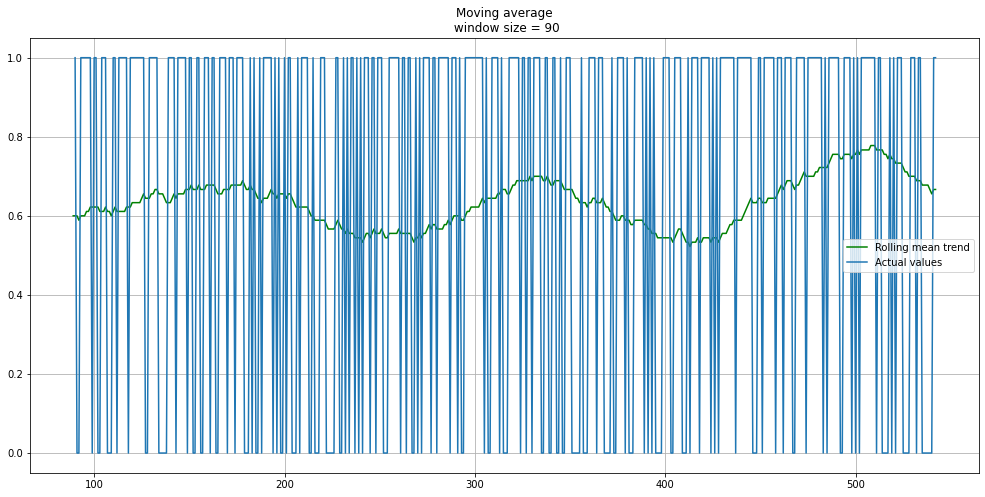

In [0]:

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(train.IsUnderRisk, 90)

# plot_moving_average(train.GrocerySales, 12)

# plot_moving_average(df.GrocerySales, 15)
# #Smooth by the previous month (30 days)
# plot_moving_average(df.GrocerySales, 30)

# #Smooth by previous quarter (90 days)
# plot_moving_average(df.GrocerySales, 90, plot_intervals=True)

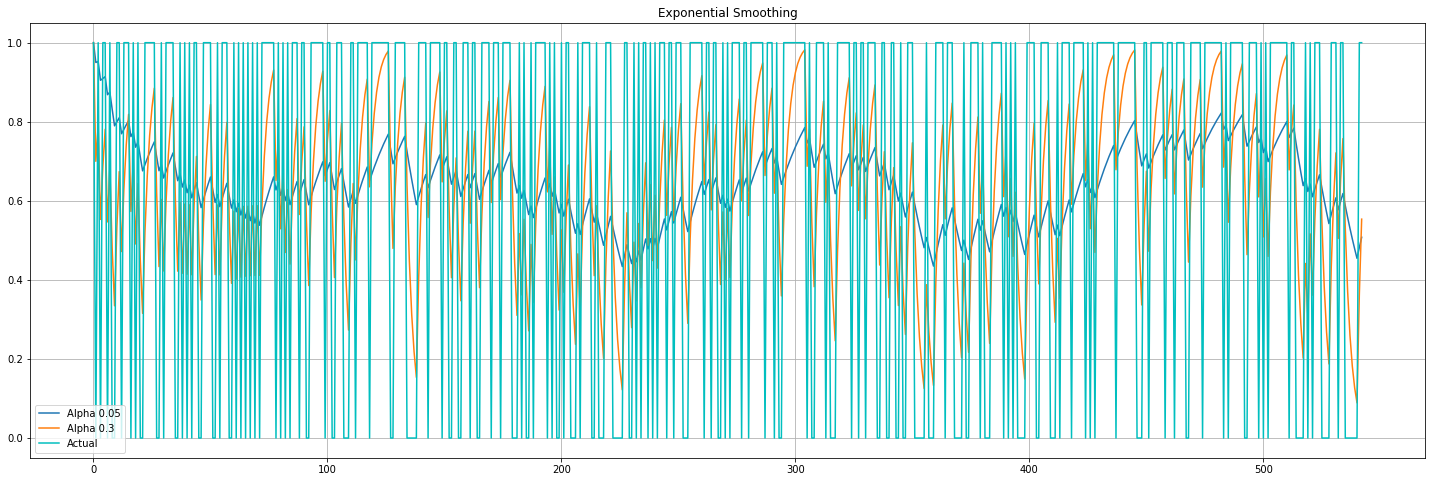

In [0]:

def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(25, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(train.IsUnderRisk, [0.05, 0.3])

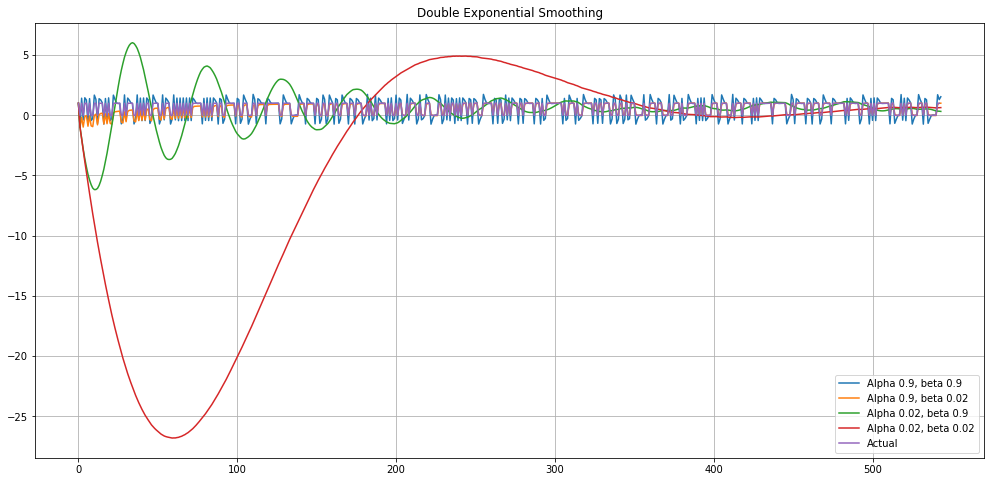

In [0]:

def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(train.IsUnderRisk, alphas=[0.9, 0.02], betas=[0.9, 0.02])

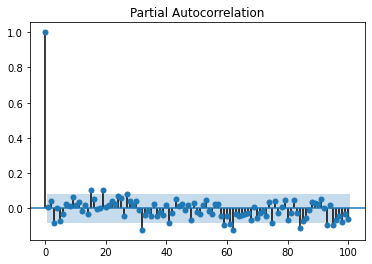

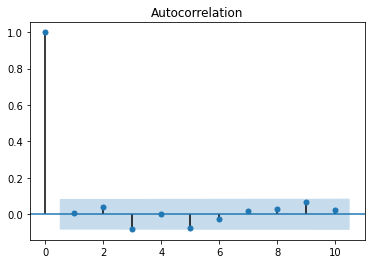

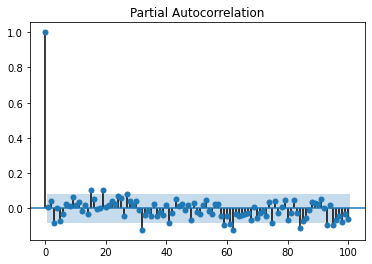

In [0]:

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(train['IsUnderRisk'], lags=10)
plot_pacf(train['IsUnderRisk'], lags=100)